# CVRP Notebook
This notebook is intended to run the top level code for the CVRP

In [1]:
import networkx as nx

from src.model import VRP, create_constraints, output_variables, create_example_2
from src.pricer import VRPPricer
from src.parse import parse

from matplotlib import pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

In [2]:
# G = parse("Instances/E/E-n22-k4.vrp")
# G = parse("E-n23-k3")
G = parse("E-n30-k3")
# G = parse("Instances/E/E-n33-k4.vrp")
# G = parse("Instances/E/E-n51-k5.vrp")
# G = parse("E-n76-k14")
# G = parse("Instances/E/E-n101-k14.vrp")
# G = parse("Instances/Uchoa/X-n101-k25.vrp")
# G.graph['min_trucks'] = 26
# G = parse("Instances/Uchoa/X-n106-k14.vrp")
# G.graph['min_trucks'] = 14
# G = parse("Instances/Uchoa/X-n110-k13.vrp")
# G.graph['min_trucks'] = 13
# G = parse("Instances/Uchoa/X-n115-k10.vrp")
# G.graph['min_trucks'] = 10
# G = parse("X-n120-k6",6)
# G = parse("Instances/Uchoa/X-n125-k30.vrp")
# G.graph['min_trucks'] = 30
# G = parse("Instances/Uchoa/X-n129-k18.vrp")
# G.graph['min_trucks'] = 18
# G = parse("Instances/Uchoa/X-n200-k36.vrp")
# G.graph['min_trucks'] = 36
# G = parse("Instances/Uchoa/X-n228-k23.vrp")
# G.graph['min_trucks'] = 23
# G = parse("Instances/Uchoa/X-n251-k28.vrp")
# G.graph['min_trucks'] = 28
# G = parse("Instances/Uchoa/X-n256-k16.vrp")
# G.graph['min_trucks'] = 16
# G = parse("Instances/Uchoa/X-n289-k60.vrp")
# G.graph['min_trucks'] = 61
# G = parse("Instances/Uchoa/X-n502-k39.vrp")
# G.graph['min_trucks'] = 39 #TODO: Ist dieses K auch das K, einer Optimallösung?

MAIN: Instance E-n30-k3
PARSE: Minimum number of trucks is 3


In [ ]:
model = VRP(G)

# Create pricer
pricer = VRPPricer(G)
pricer.data['methods'] = ["ESPPRC"]
pricer.data['max_vars']= int(1e6)
pricer.data['time_limit'] = 7200
pricer.data['farley'] = False

model.includePricer(pricer, "pricer","does pricing")

create_constraints(model,pricer,heuristic_stale_it=20, heuristic_max_it=2e8, heuristic_time=1e-6)

model.optimize()
model.hideOutput(quiet=False)

HYGESE: Did not find valid solution at iteration 3
HYGESE: Did not find valid solution at iteration 3
HYGESE: Did not find valid solution at iteration 3
HYGESE: Did not find valid solution at iteration 37
HYGESE: Found 44 initial routes in 83 rounds. Best sol val is 534.0
Writing heuristic results
SETUP: methods are ['ESPPRC']
SETUP: time_limit is 7200
SETUP: Farley is False
PRICER_PY: The maximal path length is 47
PY PRICING: The neighborhood has been fixed to 8 neighbors.
PRICER_C: Graph data successfully copied to C.
presolving:
presolving (1 rounds: 1 fast, 1 medium, 1 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 0 cliques
presolved problem has 73 variables (0 bin, 0 int, 0 impl, 73 cont) and 30 constraints
     30 constraints of type <linear>
Presolving Time: 0.00

 time | node  | left  |LP iter|LP it/n|mem/heur|mdpt |vars |cons |rows |cuts |sepa|confs|strbr|  d

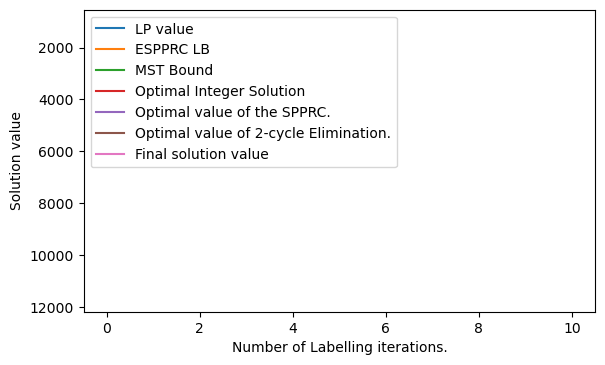

In [4]:
# This value is the exact pagewidth of latex
plt.figure(figsize=(6.6,4),dpi=100)

upper_bounds = [x for x,y in pricer.data['bounds'][pricer.data['methods'][0]]]
plt.plot(upper_bounds, label="LP value")

xmax = 0
for method in pricer.data['methods']:
    lower_bounds = []
    best_lb = pricer.data['bounds'][method][0][1]
    for x,y in pricer.data['bounds'][method]:
        if y > best_lb:
            best_lb = y
        lower_bounds.append(best_lb)
    plt.plot(lower_bounds, label=f'{method} LB')
    xmax = max(upper_bounds[0],xmax)

T = nx.minimum_spanning_tree(G)
mst = T.size(weight='weight') + min(G.edges().data('weight'),key=lambda edge: edge[2])[2]
mst = [mst for i in range(len(upper_bounds))]
plt.plot(mst, label="MST Bound")

optimal = [13332 for i in range(len(upper_bounds))]
plt.plot(optimal, label="Optimal Integer Solution")

spprc = [12308 for i in range(len(upper_bounds))]
plt.plot(spprc, label="Optimal value of the SPPRC.")

# ng8 = [481 for i in range(len(upper_bounds))]
# plt.plot(ng8, label="Optimal value of ng 8.")

cyc2 = [12784 for i in range(len(upper_bounds))]
plt.plot(cyc2, label="Optimal value of 2-cycle Elimination.")

if pricer.data['farley']:
    farley_bounds = pricer.data['farley_bound']
    plt.plot(farley_bounds, label="Farley Bound")

solval = model.getObjVal()
sol = [solval for i in range(len(upper_bounds))]
plt.plot(sol,label="Final solution value")

plt.ylim((spprc[0]*0.99,xmax*1.01))

plt.legend(loc='upper left')
plt.xlabel("Number of Labelling iterations.")
plt.ylabel("Solution value")
# plt.savefig("plots/E-n30-k3.espprc.pgf")
plt.show()

In [5]:
output_variables(model, pricer)

The solution contains the following paths: 
Only paths with associated value larger than 1e-06 are analysed.
0.0514018691588789 * x2086: (0, 22, 2, 3, 19, 0)
0.1495327102803749 * x2476: (0, 22, 2, 1, 24, 6, 3, 0)
0.09813084112149492 * x13692: (0, 18, 10, 12, 15, 20, 2, 22, 0)
0.09813084112149273 * x14822: (0, 29, 1, 2, 22, 0)
0.10280373831775802 * x17268: (0, 20, 29, 2, 22, 0)
0.05607476635514014 * x20950: (0, 21, 8, 12, 11, 15, 10, 18, 0)
0.05140186915888012 * x33581: (0, 18, 26, 6, 1, 4, 5, 2, 22, 0)
0.05140186915887923 * x36638: (0, 22, 2, 5, 4, 24, 26, 18, 0)
0.09813084112149362 * x42077: (0, 22, 2, 5, 4, 6, 24, 26, 0)
0.018691588785046676 * x53762: (0, 21, 14, 17, 13, 16, 15, 12, 11, 10, 23, 18, 0)
0.09345794392523382 * x56558: (0, 18, 23, 10, 15, 11, 12, 21, 0)
0.09813084112149568 * x57277: (0, 26, 29, 25, 27, 28, 15, 12, 11, 10, 18, 0)
0.0327102803738315 * x57695: (0, 18, 23, 10, 15, 11, 12, 14, 21, 0)
0.20093457943925297 * x60192: (0, 22, 2, 25, 27, 28, 0)
0.004672897196261867 